<a href="https://colab.research.google.com/github/Delonix7/My_Data_Science_Projects/blob/main/PhD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A1 and A2 Neurons Contribution to Dilutional Hyponatremia in Liver Cirrhosis
---
Independent variables: Liver to body weight ratio (L:B ratio),  Total number of : A1 DBH positive neruons, A2 DBH positive neruons, A1 delta FosB positive neurons, A2 delta FosB positive neurons, A1 doubled labeled cells, A2 double labeled cells, SON delta FosB positive cells, SON double labled cells.

Measured variables: Plasma copeptin as ratio of controls (cpp_as_ratios), Plasma Osmolality,  Hematocrit (Crit).

---

##Importing packages

In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
%matplotlib inline
import numpy as  np
import seaborn as sns
from scipy.stats import sem
#authenticate colabs to allow access to Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
import statsmodels.api as sm
from statsmodels.formula.api import ols

---
##Google drive authentication

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

---
##Importing the data

In [3]:
def get_data(url, file_name):
  dataframe_name = pd.DataFrame()
  data_url_list = url.split('/')
  downloaded = drive.CreateFile({'id':data_url_list[5]})
  downloaded.GetContentFile(file_name)
  dataframe_name = pd.read_csv(file_name)
  return dataframe_name

In [4]:
url = 'https://drive.google.com/file/d/1kj6cs2u_ZJR6U0cvCpdwKqOVkhgUhBId/view?usp=sharing'
file_name = 'Sap_project_data.csv'

In [5]:
sap_project_data = get_data(url, file_name)

---
##Data Preprocessing

In [6]:
sap_project_data.head(2)

,Rat ID,Injection,Surgery,L:B ratio,CPP conc,CPP as ratios,Osmolality,Crit,A1 DBH,A1 dFosB,A1 DL,A2 DBH,A2 dFosB,A2 DL,SON_dFosB,SON_DL
0,R19-134,DSAP,BDL,0.056566,111.4885,1.561760,304.0,42.5,43,19,3,24,48,1,46.0,19.0
1,R19-135,DSAP,BDL,0.041700,81.4151,1.342934,298.0,46.5,36,25,0,28,65,2,51.0,29.0


In [7]:
#Replacing spaces in column names with hyphens
sap_project_data.columns = sap_project_data.columns.str.lower()
sap_project_data.columns = sap_project_data.columns.str.replace(' ', '_')

In [8]:
sap_project_data.head(2)

,rat_id,injection,surgery,l:b_ratio,cpp_conc,cpp_as_ratios,osmolality,crit,a1_dbh,a1_dfosb,a1_dl,a2_dbh,a2_dfosb,a2_dl,son_dfosb,son_dl
0,R19-134,DSAP,BDL,0.056566,111.4885,1.561760,304.0,42.5,43,19,3,24,48,1,46.0,19.0
1,R19-135,DSAP,BDL,0.041700,81.4151,1.342934,298.0,46.5,36,25,0,28,65,2,51.0,29.0


In [9]:
sap_project_data.replace('-', np.NaN, inplace = True)

In [10]:
sap_project_data.head(2)

,rat_id,injection,surgery,l:b_ratio,cpp_conc,cpp_as_ratios,osmolality,crit,a1_dbh,a1_dfosb,a1_dl,a2_dbh,a2_dfosb,a2_dl,son_dfosb,son_dl
0,R19-134,DSAP,BDL,0.056566,111.4885,1.561760,304.0,42.5,43,19,3,24,48,1,46.0,19.0
1,R19-135,DSAP,BDL,0.041700,81.4151,1.342934,298.0,46.5,36,25,0,28,65,2,51.0,29.0


###Creating Data subsets

In [11]:
#creating subgroups for data visualizations (vertical scatterplots)
DSAP_BDL = sap_project_data.loc[sap_project_data['injection'].str.contains('DSAP') & sap_project_data['surgery'].str.contains('BDL')]
DSAP_Sham = sap_project_data.loc[sap_project_data['injection'].str.contains('DSAP') & sap_project_data['surgery'].str.contains('Sham')]
Veh_BDL = sap_project_data.loc[sap_project_data['injection'].str.contains('Vehicle') & sap_project_data['surgery'].str.contains('BDL')]
Veh_Sham = sap_project_data.loc[sap_project_data['injection'].str.contains('Vehicle') & sap_project_data['surgery'].str.contains('Sham')]

In [12]:
groups = [DSAP_Sham, DSAP_BDL, Veh_BDL, Veh_Sham]

In [13]:
column_names = list(sap_project_data.columns)

In [14]:
column_names.remove('injection')
column_names.remove('surgery')
column_names.remove('cpp_conc')
column_names.remove('rat_id')

In [15]:
print(column_names)

['l:b_ratio', 'cpp_as_ratios', 'osmolality', 'crit', 'a1_dbh', 'a1_dfosb', 'a1_dl', 'a2_dbh', 'a2_dfosb', 'a2_dl', 'son_dfosb', 'son_dl']


In [16]:
#Resetting indices to allow correct alignment of dataframes
groups = [DSAP_Sham, DSAP_BDL, Veh_BDL, Veh_Sham]
for group in groups:
  group.reset_index(inplace = True)

###Defining a class to allow easy creation of new dataframes with data on single variables

In [17]:
class Variables:
  '''Variables take in an independent variable and creates a new dataframe describing
  the values for the variable across the four groups 
  (Veh_Sham, Veh_BDL, DSAP_Sham, DSAP_BDL)
  '''
  def __init__ (self, var):
    self.var = var
    self.new_dataframe = pd.DataFrame(index = range(0, 8))

  @property
  def create_dataframe(self):
    self.new_dataframe = self.new_dataframe.assign(Veh_Sham = Veh_Sham[self.var])
    self.new_dataframe = self.new_dataframe.assign(Veh_BDL = Veh_BDL[self.var])
    self.new_dataframe = self.new_dataframe.assign(DSAP_Sham = DSAP_Sham[self.var])
    self.new_dataframe = self.new_dataframe.assign(DSAP_BDL = DSAP_BDL[self.var])
    return self.new_dataframe

In [18]:
data = {}
for column in column_names:
  new_object = Variables(column)
  data[column] = new_object.create_dataframe

In [19]:
data.keys()

dict_keys(['l:b_ratio', 'cpp_as_ratios', 'osmolality', 'crit', 'a1_dbh', 'a1_dfosb', 'a1_dl', 'a2_dbh', 'a2_dfosb', 'a2_dl', 'son_dfosb', 'son_dl'])

In [20]:
data['l:b_ratio']

,Veh_Sham,Veh_BDL,DSAP_Sham,DSAP_BDL
0,0.041009,0.091932,0.049107,0.056566
1,0.038745,0.090580,0.051786,0.041700
2,0.038983,0.064267,0.052811,0.078125
3,0.036053,0.079365,0.033217,0.041000
4,0.035789,0.060150,0.037665,0.066946
5,0.036900,0.082005,0.042146,0.060000
6,0.039604,NaN,0.038877,0.071269
7,NaN,NaN,NaN,0.032000


---
##Exploratory Data Analysis

In [21]:
sap_project_data_pair = sap_project_data[column_names].copy()

In [22]:
sap_project_data_pair.corr()

,l:b_ratio,cpp_as_ratios,osmolality,crit,a1_dbh,a1_dfosb,a1_dl,a2_dbh,a2_dfosb,a2_dl,son_dfosb,son_dl
l:b_ratio,1.000000,0.578177,-0.355437,-0.269702,0.120331,0.582780,0.493535,0.211133,0.258672,0.487290,0.539024,0.634863
cpp_as_ratios,0.578177,1.000000,-0.518832,-0.390659,0.212521,0.300912,0.328731,0.077314,0.190467,0.484058,0.324081,0.563652
osmolality,-0.355437,-0.518832,1.000000,0.378113,-0.281094,-0.382430,-0.338847,-0.151953,0.124562,-0.448561,-0.456745,-0.596742
crit,-0.269702,-0.390659,0.378113,1.000000,-0.358924,-0.306878,-0.553596,-0.196291,-0.092389,-0.327472,-0.574453,-0.574786
a1_dbh,0.120331,0.212521,-0.281094,-0.358924,1.000000,0.386013,0.249341,0.469848,0.298032,0.379540,0.289118,0.324558
a1_dfosb,0.582780,0.300912,-0.382430,-0.306878,0.386013,1.000000,0.611793,0.560536,0.447397,0.681337,0.787277,0.804125
a1_dl,0.493535,0.328731,-0.338847,-0.553596,0.249341,0.611793,1.000000,0.398485,0.226100,0.582261,0.732345,0.746854
a2_dbh,0.211133,0.077314,-0.151953,-0.196291,0.469848,0.560536,0.398485,1.000000,0.608252,0.635586,0.417288,0.435601
a2_dfosb,0.258672,0.190467,0.124562,-0.092389,0.298032,0.447397,0.226100,0.608252,1.000000,0.443702,0.287372,0.305821
a2_dl,0.487290,0.484058,-0.448561,-0.327472,0.379540,0.681337,0.582261,0.635586,0.443702,1.000000,0.596303,0.764369


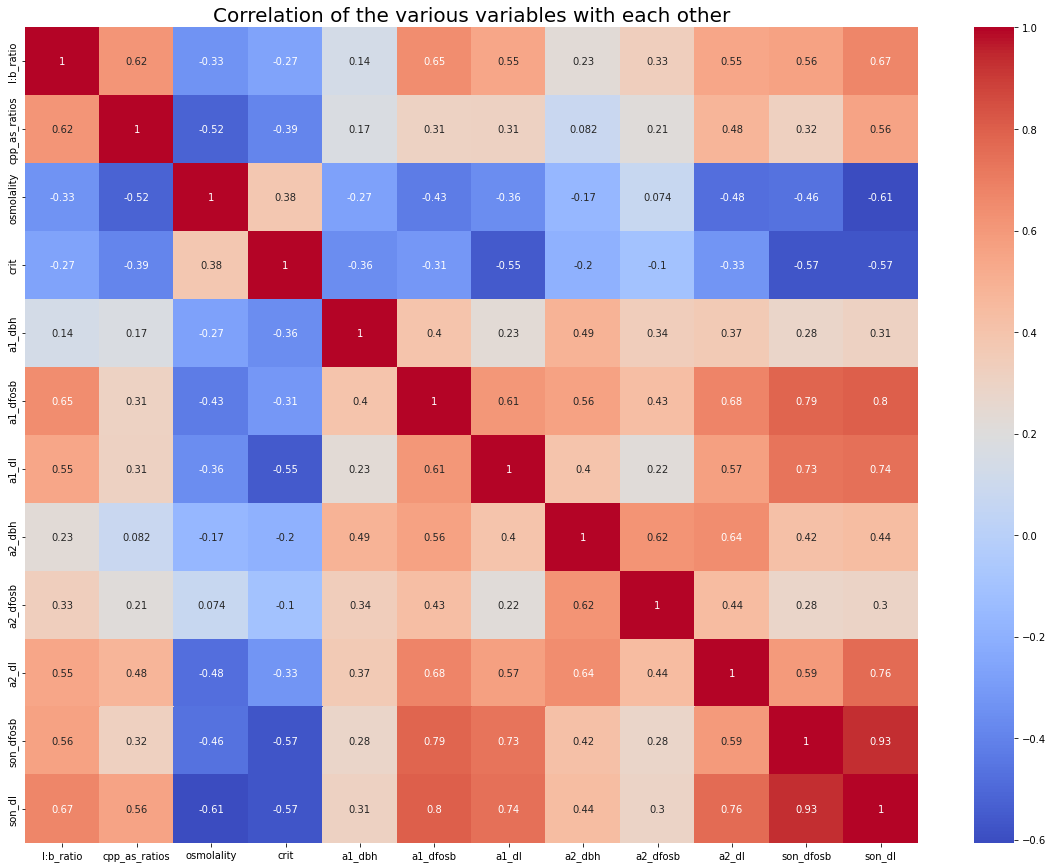

In [23]:
fig, ax = plt.subplots(figsize= (20,15))  
sns.heatmap(sap_project_data_pair.dropna().corr(), annot = True, cmap = 'coolwarm')
plt.title("Correlation of the various variables with each other", size = 20)
plt.show()

In [24]:
def draw_scatter(x, y, data):
  plt.scatter(x = data[x], y = data[y], color = 'green' )
  plt.rcParams['axes.spines.right'] = False
  plt.rcParams['axes.spines.top'] = False
  plt.xlabel(f'{x}')
  plt.ylabel(f'{y}')
  plt.title(f'{x} vs {y}')
  plt.show()

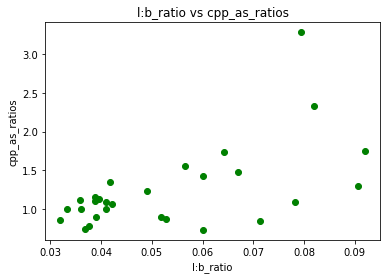

In [25]:
draw_scatter('l:b_ratio', 'cpp_as_ratios', sap_project_data)

Pairwise scatterplots of all variables

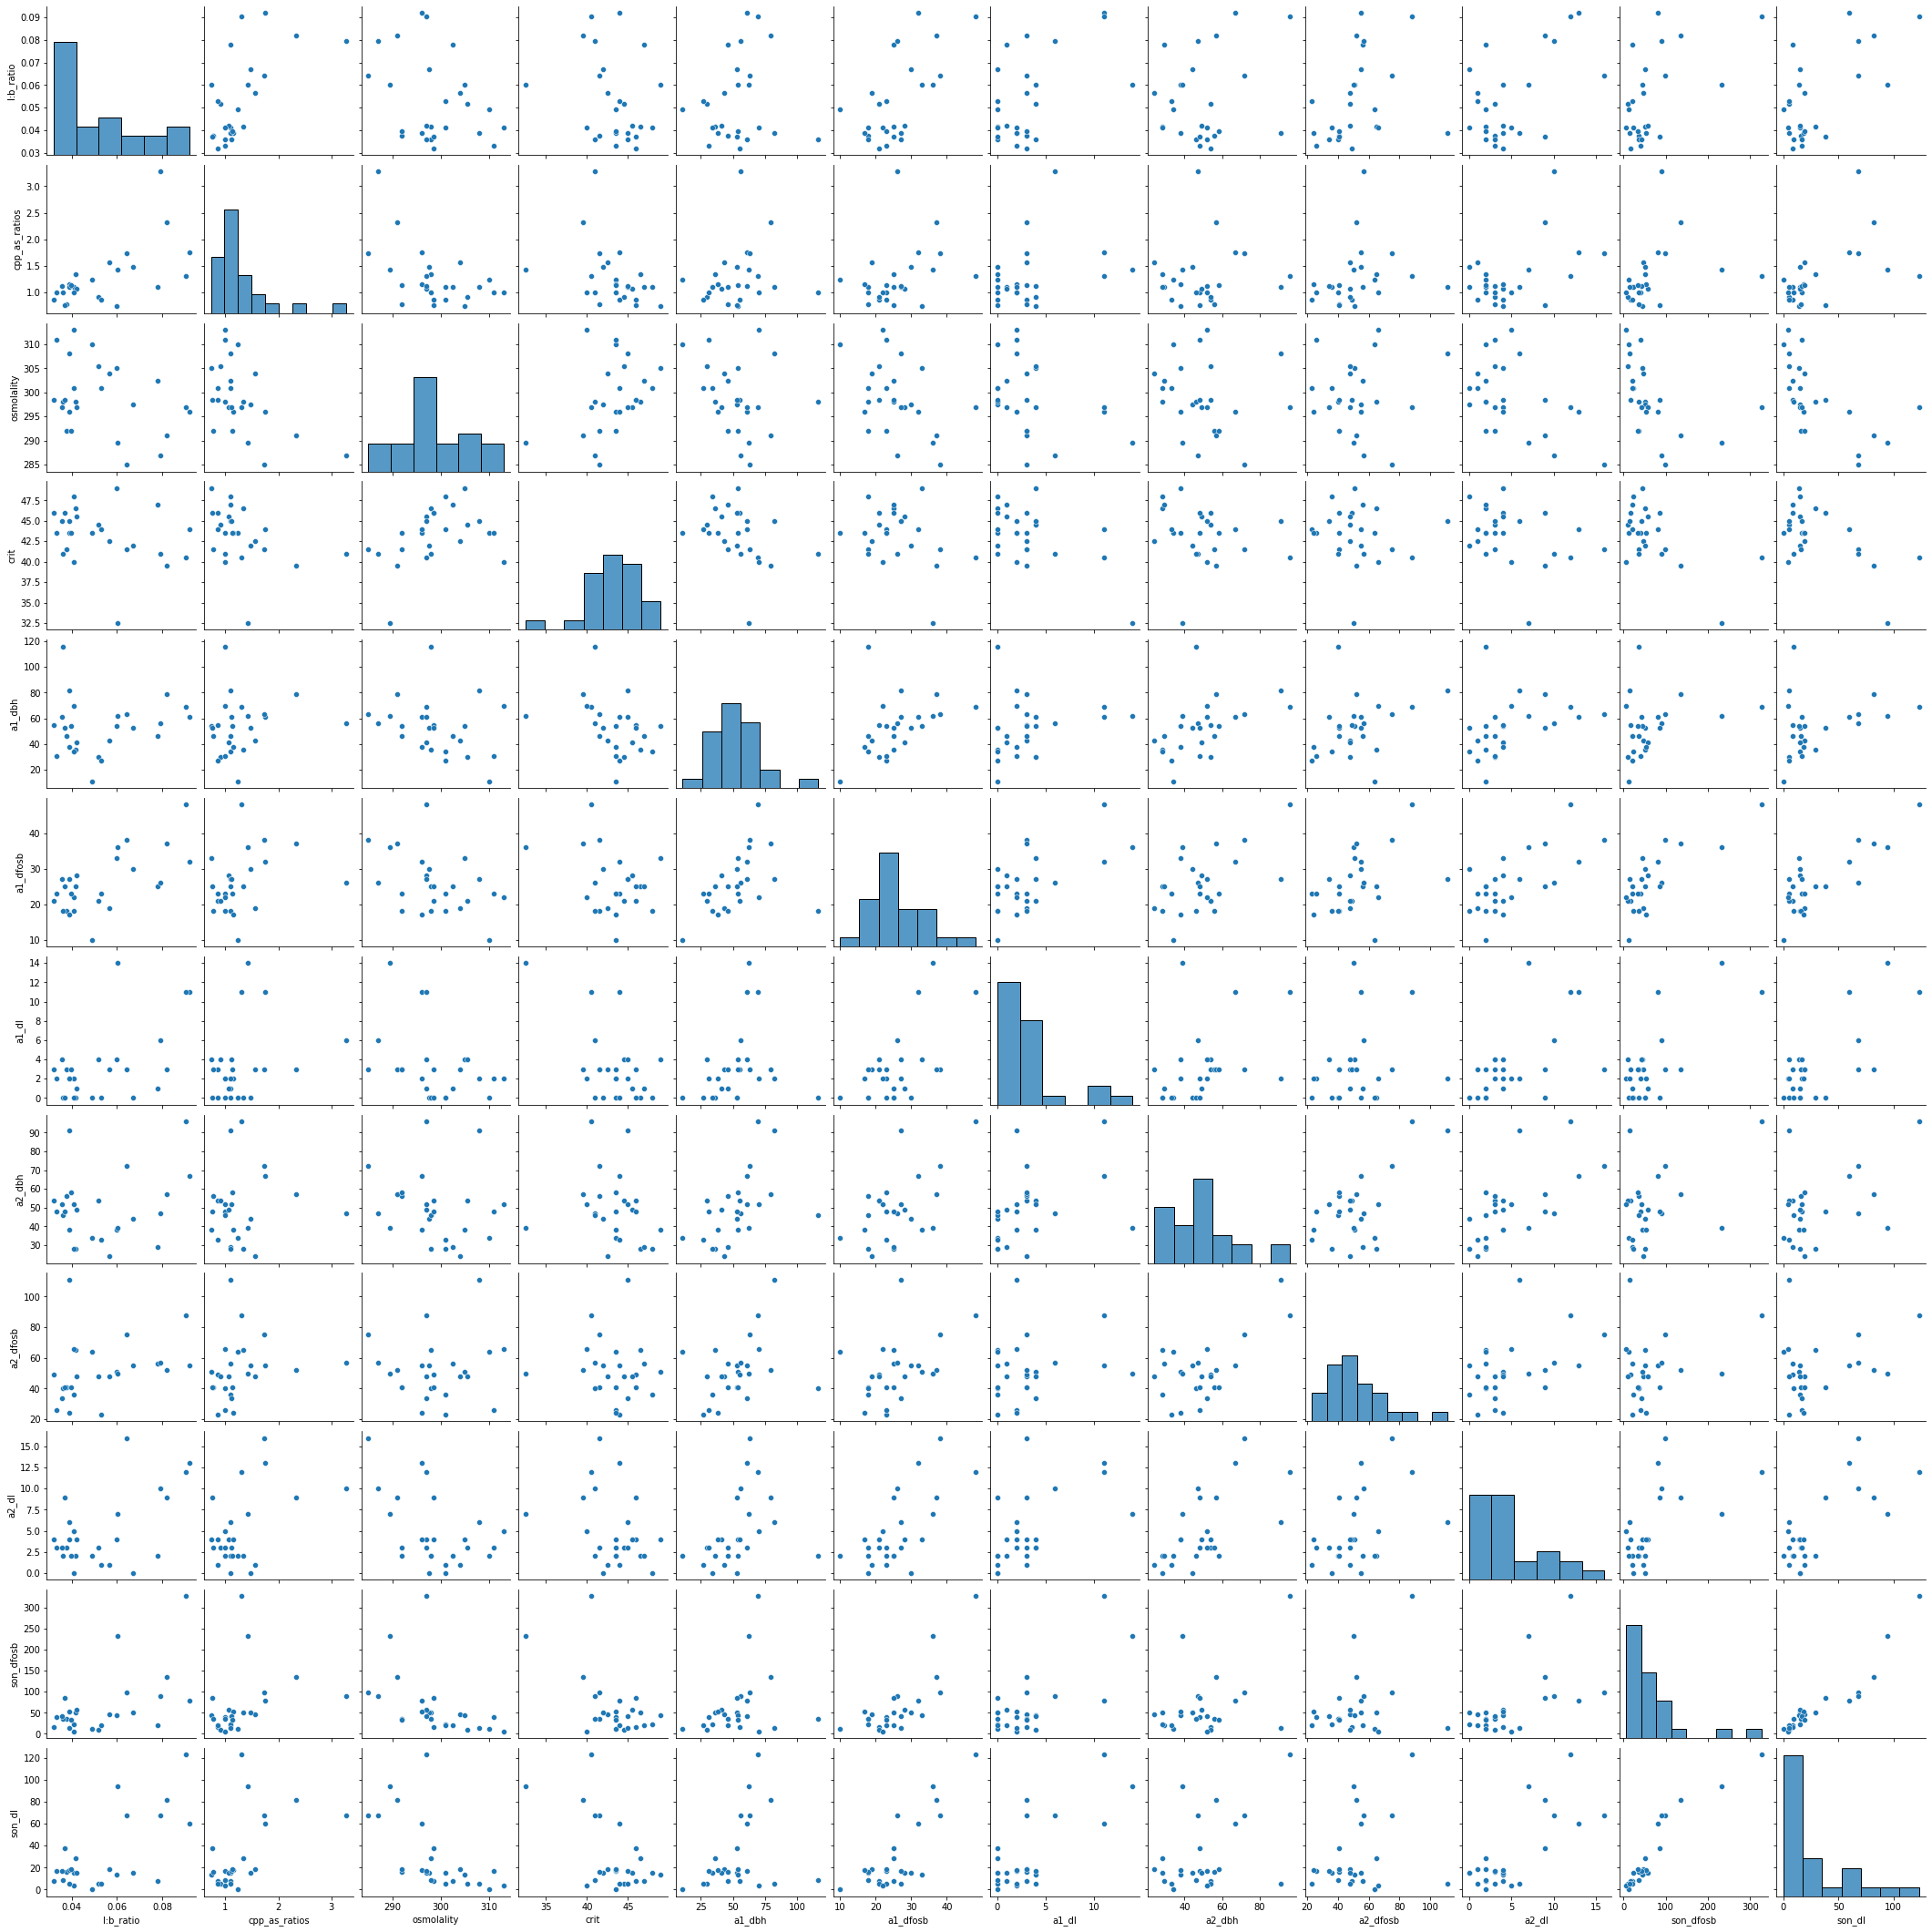

In [26]:
sns.pairplot(sap_project_data_pair.dropna())
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.show()

---
##Data Visualization and Statisitcal Analysis

In [27]:
#Creating new dataframes for scatterplot
sap_project_data_scatter = pd.DataFrame()
sap_project_data_scatter['Treatment'] = sap_project_data['injection'] +'_'+ sap_project_data['surgery']

for column in column_names:
  sap_project_data_scatter[column] = sap_project_data[column].copy()

sap_project_data_scatter['Treatment'].replace({'Vehicle_BDL': 'Veh_BDL'}, inplace =True)
sap_project_data_scatter['Treatment'].replace({'Vehicle_Sham': 'Veh_Sham'}, inplace =True)

In [28]:
def draw_bars(data, variable):
  '''
  Takes two parameters, data = the dataframe to be represented by a graph, 
  variable = variable type
  '''
  data_y = []
  data_y_error = []
  data_x = list(sap_project_data_scatter['Treatment'].unique())
  for data1 in data_x:
    data_y.append(data[variable][data1].dropna().mean())# calculate mean
    data_y_error.append(sem(data[variable][data1].dropna()))#calculate standard error
  
  plt.figure(figsize= (8,6))
  plt.bar(data_x,  data_y,  color = ['white', 'lightgrey', 'dimgray', 'black'], edgecolor = 'black') #draws barplot
  sns.swarmplot(x = 'Treatment',y = variable, data = sap_project_data_scatter, zorder = 2, 
                color = 'white', edgecolor = 'black', linewidth = 1, size = 9) #draws scatterplot, swarmplot jitters the data points
  plt.rcParams['axes.spines.right'] = False
  plt.rcParams['axes.spines.top'] = False
  plt.errorbar(x =data_x, y=data_y, yerr =data_y_error, fmt = ' ' , color = 'black', capsize = 10)#appends error bars
  plt.ylabel(f'{variable}', size =15)
  # plt.xlabel('Groups', size = 15)
  plt.title(f'Graph for {variable}', size = 15)
  plt.show()

  #performs Two-way ANOVA
  print(f'\n\nTwo-Way ANOVA for {variable}')
  model = ols(f'''sap_project_data['{column}']  ~ sap_project_data['surgery'] 
  + sap_project_data['injection'] 
  + sap_project_data['surgery']: sap_project_data['injection']''', data = sap_project_data).fit()
  display(sm.stats.anova_lm(model, typ = 2))
 

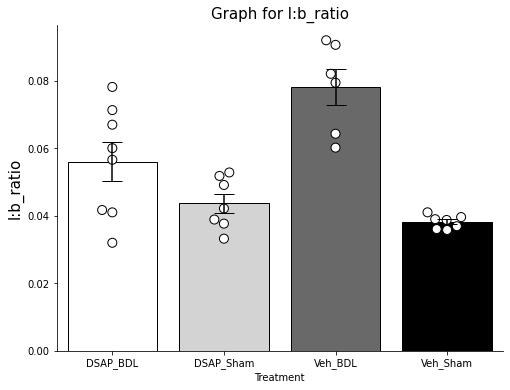



Two-Way ANOVA for l:b_ratio


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],0.004387,1.0,33.806475,0.000005
sap_project_data['injection'],0.000461,1.0,3.551646,0.071654
sap_project_data['surgery']:sap_project_data['injection'],0.001320,1.0,10.169498,0.003945
Residual,0.003114,24.0,NaN,NaN


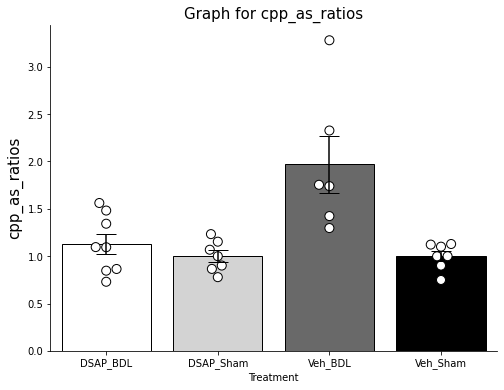



Two-Way ANOVA for cpp_as_ratios


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],1.871554,1.0,12.349992,0.001779
sap_project_data['injection'],1.205224,1.0,7.953021,0.009476
sap_project_data['surgery']:sap_project_data['injection'],1.230333,1.0,8.118709,0.008851
Residual,3.637030,24.0,NaN,NaN


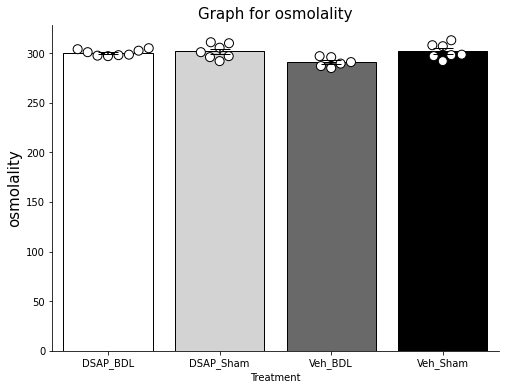



Two-Way ANOVA for osmolality


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],236.813417,1.0,6.785728,0.015530
sap_project_data['injection'],149.116348,1.0,4.272828,0.049675
sap_project_data['surgery']:sap_project_data['injection'],161.742283,1.0,4.634616,0.041599
Residual,837.569940,24.0,NaN,NaN


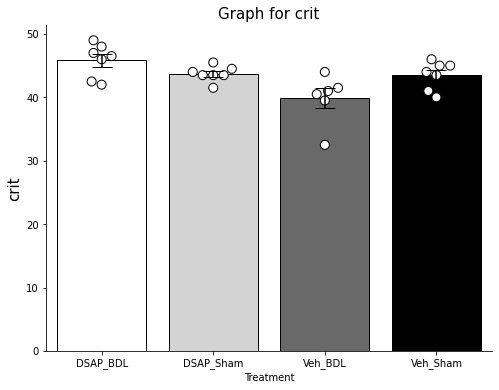



Two-Way ANOVA for crit


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],2.806374,1.0,0.412125,0.527240
sap_project_data['injection'],60.692363,1.0,8.912864,0.006612
sap_project_data['surgery']:sap_project_data['injection'],56.700952,1.0,8.326713,0.008346
Residual,156.619048,23.0,NaN,NaN


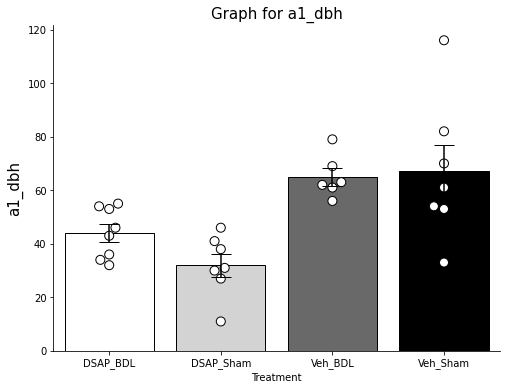



Two-Way ANOVA for a1_dbh


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],216.228575,1.0,0.877659,0.358176
sap_project_data['injection'],5436.000736,1.0,22.064396,0.000090
sap_project_data['surgery']:sap_project_data['injection'],345.552835,1.0,1.402578,0.247889
Residual,5912.875000,24.0,NaN,NaN


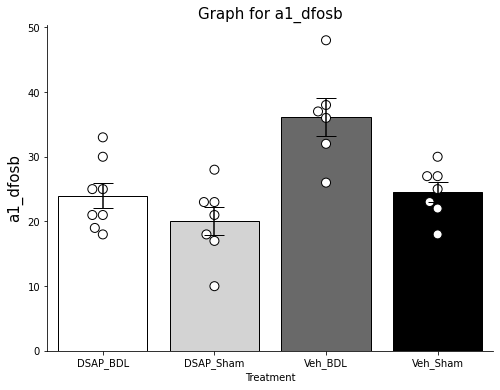



Two-Way ANOVA for a1_dfosb


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],394.196175,1.0,12.571574,0.001645
sap_project_data['injection'],480.754050,1.0,15.332049,0.000652
sap_project_data['surgery']:sap_project_data['injection'],99.912617,1.0,3.186380,0.086900
Residual,752.547619,24.0,NaN,NaN


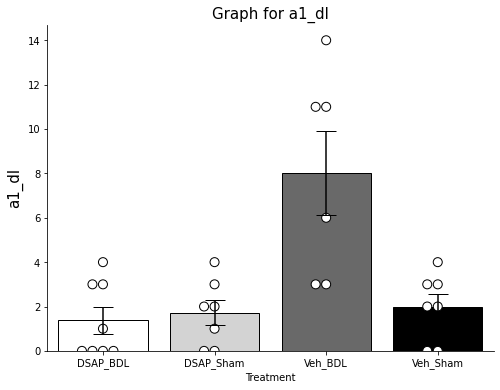



Two-Way ANOVA for a1_dl


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],47.136018,1.0,7.284214,0.012537
sap_project_data['injection'],81.166421,1.0,12.543138,0.001662
sap_project_data['surgery']:sap_project_data['injection'],69.601436,1.0,10.755931,0.003165
Residual,155.303571,24.0,NaN,NaN


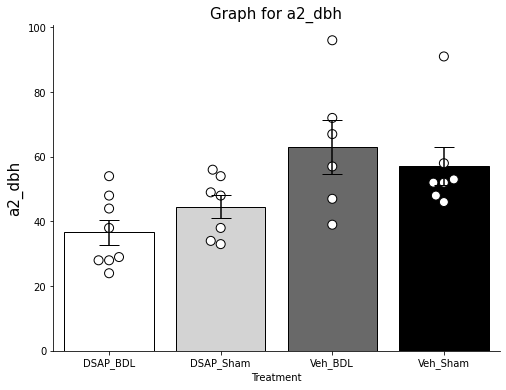



Two-Way ANOVA for a2_dbh


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],16.574242,1.0,0.081639,0.777540
sap_project_data['injection'],2608.191458,1.0,12.847057,0.001495
sap_project_data['surgery']:sap_project_data['injection'],330.004971,1.0,1.625491,0.214533
Residual,4872.446429,24.0,NaN,NaN


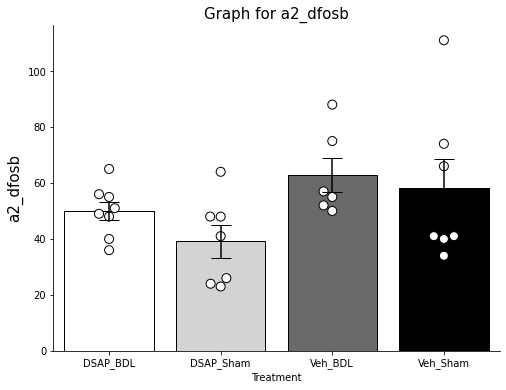



Two-Way ANOVA for a2_dfosb


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],445.292402,1.0,1.371089,0.253120
sap_project_data['injection'],1762.304124,1.0,5.426267,0.028577
sap_project_data['surgery']:sap_project_data['injection'],65.862543,1.0,0.202796,0.656515
Residual,7794.547619,24.0,NaN,NaN


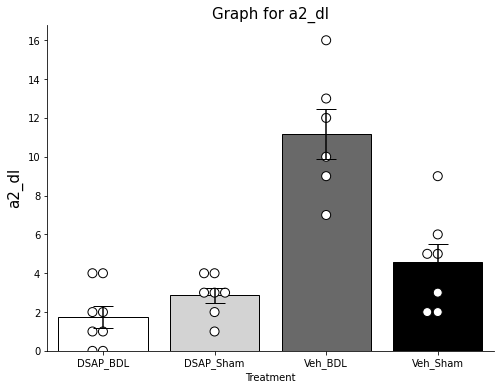



Two-Way ANOVA for a2_dl


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],42.354144,1.0,9.003159,6.197980e-03
sap_project_data['injection'],211.558174,1.0,44.970611,6.169030e-07
sap_project_data['surgery']:sap_project_data['injection'],102.751350,1.0,21.841704,9.525061e-05
Residual,112.904762,24.0,NaN,NaN


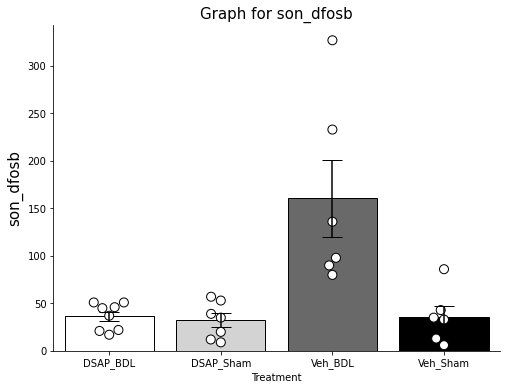



Two-Way ANOVA for son_dfosb


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],22511.947195,1.0,9.158694,0.006007
sap_project_data['injection'],28944.298843,1.0,11.775613,0.002277
sap_project_data['surgery']:sap_project_data['injection'],24176.362329,1.0,9.835840,0.004632
Residual,56533.690476,23.0,NaN,NaN


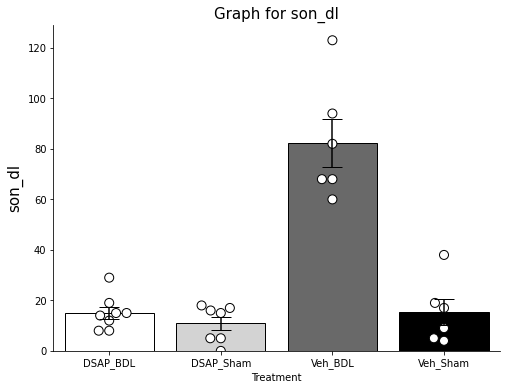



Two-Way ANOVA for son_dl


,sum_sq,df,F,PR(>F)
sap_project_data['surgery'],6991.267492,1.0,38.805783,2.347847e-06
sap_project_data['injection'],9079.269140,1.0,50.395461,3.126430e-07
sap_project_data['surgery']:sap_project_data['injection'],6606.892032,1.0,36.672265,3.550018e-06
Residual,4143.690476,23.0,NaN,NaN


In [29]:
for column in column_names:
  draw_bars(data, column)